In [1]:
import torch
from torch import nn

# understanding

## RNN cell

In [2]:
input_size = 6 
hidden_size = 3
time_step = 5
n = 4

In [3]:
rnn = nn.RNNCell(input_size=input_size,hidden_size=hidden_size,bias=False)

In [4]:
rnn.weight_hh
#? shape [hidden,hidden]

Parameter containing:
tensor([[-0.3647,  0.0296,  0.1803],
        [-0.3055, -0.1300, -0.4732],
        [-0.0404,  0.2164,  0.1798]], requires_grad=True)

In [5]:
rnn.weight_ih
#? shape [hidden,input]

Parameter containing:
tensor([[ 0.1958, -0.3232,  0.4695,  0.4729, -0.2073,  0.0308],
        [ 0.0351, -0.0463, -0.2439,  0.4978, -0.1700, -0.1514],
        [-0.2154, -0.1728, -0.0040, -0.1036, -0.3437,  0.0540]],
       requires_grad=True)

In [6]:
input = torch.randn(time_step,n,input_size)
hx = torch.randn(n,hidden_size)
initial_hx = hx
output = []
for i in range(time_step):
    hx = rnn(input[i],hx)
    output.append(hx) 

In [7]:
output[0].shape

torch.Size([4, 3])

In [8]:
output[0] == torch.tanh(torch.matmul(input[0],rnn.weight_ih.T) + torch.matmul(initial_hx,rnn.weight_hh.T))

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

In [9]:
from argparse import Namespace
from collections import (
    OrderedDict,
    Counter
)
from functools import partial
from pathlib import Path

# torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import (
    DataLoader,
    default_collate
)
from torch.utils.data.backward_compatibility import worker_init_fn
## other 
from torchdata import datapipes as dp
from torchtext import vocab
from torchmetrics import Accuracy

# manipulation
import numpy as np

# visual
import matplotlib.pyplot as plt

# other 
from tqdm import tqdm

In [10]:
args = Namespace(
    # data
    data_base_path = "../../data/surnames/",
    dataset = ["train","val","test"],
    
    # vocab
    mask_tkn = "<MASK>",
    unk_tkn = "<UNK>",
    beg_tkn = "<B>",
    end_tkn = "<E>",
    
    # model 
    embed_dim = 100,
    hidden_size = 64,
    model_base_path = "../../models/seq_model/rnn/",
    model_filename = "model.pth",
    
    # Training
    num_epochs = 100,
    batch_size = 64,
    learning_rate = 1e-3,
    early_stopping_criteria = 5,
    
    # runtime
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
)
for k,v in args._get_kwargs():
    if "base" in k:
        Path(v).mkdir(parents=True,exist_ok=True)

# Datapipe

In [11]:
def build_pipe_dict(args=args):
    pipe_dict = {}
    for fname in args.dataset:
        pipe = dp.iter.FileOpener([args.data_base_path+f"{fname}.csv"])
        pipe = pipe.parse_csv(skip_lines=1)
        pipe_dict[fname] = pipe
    return pipe_dict

In [12]:
pipe_dict = build_pipe_dict()
pipe_dict

{'train': CSVParserIterDataPipe,
 'val': CSVParserIterDataPipe,
 'test': CSVParserIterDataPipe}

In [13]:
len(list(pipe_dict["train"])),len(list(pipe_dict["val"])),len(list(pipe_dict["test"]))

(7683, 1647, 1647)

In [14]:
next(iter(pipe_dict["train"]))

['Essop', 'English']

In [15]:
next(iter(pipe_dict["val"]))

['Ingleby', 'English']

In [16]:
next(iter(pipe_dict["test"]))

['Readle', 'English']

In [17]:
def build_vocab_dict(train_pipe,args):
    char_counter = Counter()
    nation_counter = Counter()
    max_seq_length = -1
    for name,nation in train_pipe:
        max_seq_length = max(len(name),max_seq_length)
        char_counter.update(name)
        nation_counter.update([nation])
        
        
    sort_fn = lambda kf : (-kf[1],kf[0])
    char_sort_tuples = sorted(char_counter.items(),key=sort_fn)
    nation_sort_tuples = sorted(nation_counter.items(),key=sort_fn)
    
    char_vocab = vocab.vocab(ordered_dict=OrderedDict(char_sort_tuples),
                             specials=[args.mask_tkn,
                                       args.unk_tkn,
                                       args.beg_tkn,
                                       args.end_tkn])
    char_vocab.set_default_index(char_vocab[args.unk_tkn])
    char_vocab.max_seq_length = max_seq_length + 2
    nation_vocab = vocab.vocab(OrderedDict(nation_sort_tuples))
    freq = [count for _,count in nation_sort_tuples]
    nation_vocab.class_weights = 1.0 / torch.tensor(freq,dtype=torch.float32)
    
    return {"char":char_vocab,
            "nation":nation_vocab}
    

In [18]:
vocab_dict = build_vocab_dict(pipe_dict["train"],args)
vocab_dict

{'char': Vocab(), 'nation': Vocab()}

In [19]:
len(vocab_dict["char"]) , len(vocab_dict["nation"])

(83, 18)

In [20]:
vocab_dict["char"].max_seq_length

19

In [21]:
vocab_dict["nation"].class_weights

tensor([0.0005, 0.0006, 0.0009, 0.0018, 0.0024, 0.0025, 0.0034, 0.0055, 0.0060,
        0.0063, 0.0065, 0.0078, 0.0092, 0.0119, 0.0189, 0.0192, 0.0250, 0.0263])

In [22]:
def vectorizer(name,char_vocab,args=args):
    indices = [char_vocab[args.beg_tkn]]
    indices.extend(char_vocab.lookup_indices(list(name)))
    indices.append(char_vocab[args.end_tkn])
    
    vector = np.zeros(char_vocab.max_seq_length,dtype=np.int64)
    vector[:(a:=len(indices))] = indices
    vector[a:] = char_vocab[args.mask_tkn]
    
    return vector,a

In [23]:
vectorizer("lak",vocab_dict["char"])

(array([ 2, 11,  4, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dtype=int64),
 5)

In [24]:
def create_dataset(vocab_dict,args,row):
    char_vector,vec_length = vectorizer(row[0],vocab_dict["char"],args)
    nation_idx = vocab_dict["nation"][row[1]]
    
    return {"x":char_vector,
            "y":nation_idx,
            "vec_length":vec_length}

In [25]:
def build_dataset_dict(pipe_dict,vocab_dict,args):
    dataset_dict = {}
    fn = partial(create_dataset,vocab_dict,args)
    for dataset,pipe in pipe_dict.items():
        if dataset == "train":
            pipe = pipe.shuffle()
        
        dataset_dict[dataset] = pipe.map(fn)
    
    return dataset_dict   

In [26]:
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)
dataset_dict

{'train': MapperIterDataPipe,
 'val': MapperIterDataPipe,
 'test': MapperIterDataPipe}

In [27]:
len(list(dataset_dict["train"])),len(list(dataset_dict["val"])),len(list(dataset_dict["test"]))

(7683, 1647, 1647)

In [28]:
def collate_fn(args,x):   
    return {k:v.to(args.device)
            for k,v in default_collate(x).items()}

In [29]:
def generate_batches(dataset,args=args,shuffle=False):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=args.batch_size,
                            drop_last=True,
                            worker_init_fn=worker_init_fn,
                            shuffle=shuffle,
                            collate_fn=partial(collate_fn,args))
    for batch in dataloader:
        yield batch

In [30]:
len(list(generate_batches(dataset_dict["train"]))),len(list(generate_batches(dataset_dict["val"]))),len(list(generate_batches(dataset_dict["val"])))

(120, 25, 25)

In [31]:
sample = next(iter(generate_batches(dataset_dict["train"])))
sample

{'x': tensor([[ 2, 44, 10,  ...,  0,  0,  0],
         [ 2, 43,  5,  ...,  0,  0,  0],
         [ 2, 35,  6,  ...,  0,  0,  0],
         ...,
         [ 2, 37,  6,  ...,  0,  0,  0],
         [ 2, 26, 14,  ...,  0,  0,  0],
         [ 2, 27,  9,  ...,  0,  0,  0]]),
 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'vec_length': tensor([ 7, 11, 12, 10, 12,  7,  8,  9,  8,  8,  9,  8,  8,  6,  8,  9,  7, 10,
         11,  7,  6,  6,  8,  9, 10,  9,  7,  8,  8, 10,  9,  8, 10, 11, 10, 10,
          9, 11,  9,  9, 10,  9,  8,  7,  9, 11,  9,  8,  9,  9,  8,  7, 12,  9,
          9,  8,  6,  8,  6,  8,  9,  7,  6,  6])}

In [32]:
next(iter(generate_batches(dataset_dict["val"])))

{'x': tensor([[ 2, 50,  8,  ...,  0,  0,  0],
         [ 2, 32,  7,  ...,  0,  0,  0],
         [ 2, 40,  4,  ...,  0,  0,  0],
         ...,
         [ 2, 34,  6,  ...,  0,  0,  0],
         [ 2, 36,  5,  ...,  0,  0,  0],
         [ 2, 45,  4,  ...,  0,  0,  0]]),
 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'vec_length': tensor([ 9,  9,  8,  6,  6,  9,  7, 10,  8,  8,  9, 11,  8, 10,  9,  8, 10, 12,
          9, 11, 11,  8,  8, 11,  9,  8,  9,  7,  9, 10,  9,  8,  6,  8, 11,  7,
          7, 14, 11,  7, 11,  9,  7,  9,  6,  9,  7, 11, 11,  8,  9, 10,  9, 13,
          8,  9,  7, 10, 11, 10,  8,  8,  8, 10])}

In [33]:
next(iter(generate_batches(dataset_dict["test"])))

{'x': tensor([[ 2, 34,  5,  ...,  0,  0,  0],
         [ 2, 26,  5,  ...,  0,  0,  0],
         [ 2, 24, 19,  ...,  0,  0,  0],
         ...,
         [ 2, 34,  4,  ...,  0,  0,  0],
         [ 2, 25, 20,  ...,  0,  0,  0],
         [ 2, 27,  5,  ...,  0,  0,  0]]),
 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'vec_length': tensor([ 8,  9,  9, 10,  8, 12,  9,  8,  7,  9,  8,  7, 13,  8, 10,  7,  7,  8,
          7,  6,  9,  8,  7,  9,  8, 10,  7, 10,  9,  7,  7,  9, 12,  6,  7,  6,
          8,  9,  9,  8,  7,  7,  6,  8,  8,  8,  9,  7,  8,  7,  7,  9,  5,  9,
          8,  6,  9, 10,  8,  9,  9,  8,  9, 11])}

# Model

In [34]:
class ElmanRNN(nn.Module):
    def __init__(self,input_size,hidden_size,batch_first=False) -> None:
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size=input_size,
                                   hidden_size=hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size
        
    def _initial_hidden(self,batch_size):
        return torch.zeros((batch_size,self.hidden_size))
        
    def forward(self,x_in,initial_hidden=None):
        if self.batch_first:
            batch_size,seq_size,feat_size = x_in.size()
            # swapping the batch and seq so that easy to perform the time step
            x_in = x_in.permute(1,0,2)
        else:
            seq_size,batch_size,feat_size = x_in.size()
            
        hiddens = []
        
        if initial_hidden is None:
            initial_hidden  = self._initial_hidden(batch_size).to(x_in.device)
        
        hidden_t = initial_hidden
        
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t],hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)
        
        
        if self.batch_first:
            hiddens = hiddens.permute(1,0,2)
        
        return hiddens

In [35]:
elman_rnn = ElmanRNN(input_size=10,
                     hidden_size=args.hidden_size,batch_first=True)

elman_rnn(torch.rand(size = (2,vocab_dict["char"].max_seq_length,10))).shape

torch.Size([2, 19, 64])

In [36]:
def name_end_out(y_out,x_lengths):
    # move before the arg.end_tkn
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    
    out = []
    for batch_idx,seq_end in enumerate(x_lengths):
        out.append(y_out[batch_idx,seq_end])
    
    return torch.stack(out)

In [37]:
class SurnameClassifier(nn.Module):
    def __init__(self,embedding_size,num_embedding,num_classes,
                 rnn_hidden_size,batch_first=True,padding_idx=0) -> None:
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=num_embedding,
                                  embedding_dim=embedding_size,
                                  padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                            hidden_size=rnn_hidden_size,
                            batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=num_classes)
    
    def forward(self,x_in,x_lengths=None,apply_softmax=False):
        # shape [batch,seq]
        x_embed = self.embed(x_in)
        # shape [batch,seq,emb]
        y_out = self.rnn(x_embed)
        # shape [batch,seq,hidden]
        
        if x_lengths is not None:
            # use the output of name end step in time step
            y_out = name_end_out(y_out,x_lengths)
        else:
            # use the last output step in time step
            y_out = y_out[:,-1,:]
        # shape [batch,hidden]
          
        y_out = F.relu(self.fc1(F.dropout(y_out,0.5)))
        # [batch,hidden]
        y_out = self.fc2(F.dropout(y_out,0.5))
        # [batch,num_classes]
        
        if apply_softmax:
            y_out = F.softmax(y_out,dim=1)
        
        return y_out

In [38]:
classifier  = SurnameClassifier(embedding_size=args.embed_dim,
                                num_embedding=len(vocab_dict["char"]),
                                num_classes=len(vocab_dict["nation"]),
                                rnn_hidden_size=args.hidden_size)
classifier(sample["x"]).shape

torch.Size([64, 18])

# Training

# helper functions

In [39]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e5,
            "epoch_index":0,
            "model_filepath":args.model_base_path+args.model_filename,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}

def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filepath"])
        train_state["stop_early"] = False
    
    elif train_state["epoch_index"] >= 1:
        loss_tm1 , loss_t = train_state["val_loss"][-2:]
        if loss_t >= train_state["early_stopping_val"]:
            train_state["early_stopping_step"] +=1
        else:
            torch.save(model.state_dict(),train_state["model_filepath"])
            train_state["early_stopping_step"] = 0
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    
    return train_state

## initialize

In [40]:
pipe_dict = build_pipe_dict(args)
vocab_dict = build_vocab_dict(pipe_dict['train'],args)
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)

In [41]:
classifier = SurnameClassifier(embedding_size=args.embed_dim,
                               num_embedding=len(vocab_dict["char"]),
                               num_classes=len(vocab_dict["nation"]),
                               rnn_hidden_size=args.hidden_size).to(args.device)

loss_fn = nn.CrossEntropyLoss(vocab_dict["nation"].class_weights.to(args.device))
acc_fn = Accuracy(task="multiclass",num_classes=len(vocab_dict["nation"])).to(args.device)
optimizer = optim.Adam(params=classifier.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",factor=0.5,patience=1)
train_state = make_train_state(args)

## Loop

In [42]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # get the data
    batch_generator = generate_batches(dataset=dataset_dict["val"],shuffle=True)
    classifier.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        classifier.zero_grad()
        logits = classifier(batch_dict["x"],batch_dict["vec_length"])
        
        # loss
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val 
    batch_generator = generate_batches(dataset_dict["train"])
    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = classifier(batch_dict["x"],batch_dict["vec_length"])
            
            # loss
            loss = loss_fn(logits,batch_dict["y"])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) /(batch_idx+1)
            
            # acc
            acc = acc_fn(logits,batch_dict["y"])
            acc_t = acc.item()
            running_acc += (acc_t - running_acc) / (batch_idx+1)   
            
    train_state["val_loss"].append(running_loss)         
    train_state["val_acc"].append(running_acc)
    
    scheduler.step(train_state["val_loss"][-1])
    
    if train_state["stop_early"]:
        break          

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Lenovo\anaconda3\envs\nlp\lib\site-packages\torch\utils\data\graph_settings.py:74: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(
100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


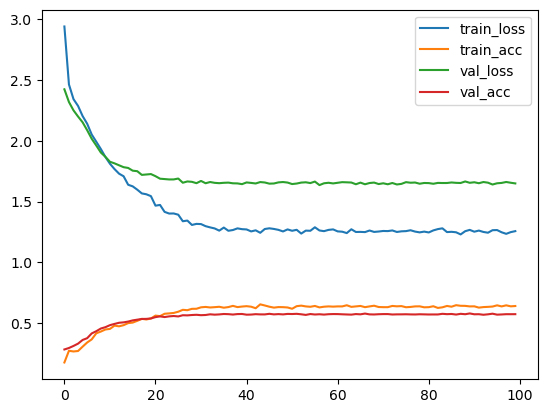

In [43]:
plt.plot(train_state["train_loss"],label="train_loss")
plt.plot(train_state["train_acc"],label="train_acc")
plt.plot(train_state["val_loss"],label="val_loss")
plt.plot(train_state["val_acc"],label="val_acc")
plt.legend();

In [44]:
batch_generator = generate_batches(dataset_dict["test"])
classifier.eval()
running_acc = 0.0 
running_loss = 0.0

for batch_idx,batch_dict in enumerate(batch_generator):
    with torch.inference_mode():
        logits = classifier(batch_dict["x"],batch_dict["vec_length"])
        # loss
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1) 
        
train_state["test_loss"]= running_loss
train_state["test_acc"] = running_acc

In [45]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.4640465426445006;
Test Accuracy: 0.5925


# Inference

In [46]:
def predict_nationality(name,vocab_dict,classifier,args=args):
    name_vector,name_length = vectorizer(name,vocab_dict["char"],args)
    name_vector = torch.tensor(name_vector).unsqueeze(dim=0)
    name_length = torch.tensor([name_length],dtype=torch.int64)
    
    result = classifier(name_vector,name_length,apply_softmax=True)
    prob_val,indices = result.max(dim=1)
    
    pred_nation = vocab_dict["nation"].lookup_tokens([indices.item()])[-1]
    return pred_nation,prob_val.item()

In [47]:
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname,vocab_dict,classifier))

('Russian', 0.2506890892982483)
('Italian', 0.2137979120016098)
('English', 0.40499022603034973)
('Japanese', 0.3591243326663971)
